L'objectif de ce projet est de créer un modèle de prédiction de tags associés à des questions sur StackOverflow. 

Pour cela on a récupéré un peu moins de 50000 questions postés par les utilisateurs, ainsi que les tags associés à chaque question.

Dans ce premier notebook on effectue le nettoyage (tokénisation, racinisation, suppression des stop words, etc...), l'exploration des données, puis on réalise la vectorisation du corpus de questions grâce aux algorithmes BOW et TF-IDF.

On créé également un plongement des tags en 2 dimensions grâce à la combinaison des algorithmes Word2vect et t-SNE.


# Sommaire

>[Sommaire](#scrollTo=xoxUSr-hQJGb)

>[Montage du drive](#scrollTo=ViwTxRxlFZXi)

>[Importations et options d'affichage du dataframe](#scrollTo=z69tmZ4PvGdA)

>[Fonctions de visualisation](#scrollTo=f75bD5Kp6WLj)

>[I - Datasets infos](#scrollTo=viOIJGhp-NyW)

>[II - Fonction de traitement et d'analyse du corpus (tokenisation, nettoyage, statistiques sur les mots)](#scrollTo=s6P3iQTxZDXG)

>[III - Tags : nettoyage et exploration](#scrollTo=8UXJyL9wckyz)

>>[Tokenisation des tags](#scrollTo=9oLrebqEY1tS)

>>[Synonymes](#scrollTo=mPyZGlCPN4IV)

>>[Fréquences](#scrollTo=y_-IYd4xOCVC)

>>[Selection des tags les plus frequents](#scrollTo=-JNfZIjSqomT)

>[IV - Questions : nettoyage et exploration](#scrollTo=_zGQ1jD6LBAq)

>>[Suppresion des tags html dans le body](#scrollTo=Tr7ylBGzluJ9)

>>[Tokenisation sans nettoyage (pour avoir un élément de comparaison)](#scrollTo=FmqcDOVQRp1Q)

>>[Tokenisation avec lemmatisation et suppression de mots](#scrollTo=F2oM9-vG1rmJ)

>>[Statistiques sur le corpus](#scrollTo=9zQGobk9NbFP)

>>>[Nombres de mots dans les questions](#scrollTo=2ShN2-kWcmcf)

>>>[Fréquences des mots](#scrollTo=ACvvRj6Z2-8L)

>>>>[Nombre de mots par fréquence d'apparition](#scrollTo=Y-bgLyBzQXYi)

>>>>[Mots les plus fréquents](#scrollTo=or_YZAjQQd0J)

>>[Ajout de Stopwords](#scrollTo=whirkGLIxfUd)

>[V - Vectorisations BOW et TF-IDF](#scrollTo=GqyBXqb1UQNh)

>>[Vectorisation fonctions](#scrollTo=CgwjzYTstfLz)

>>[Nombre de mots selectionnés (i.e. de features) en fonction de min_df](#scrollTo=sPKSBg5cJypX)

>>[Questions après vectorisation](#scrollTo=8CtVDfYVklPX)

>>[Vectorisation exemples](#scrollTo=3Pxv_pvuVA5Y)

>[VI - Word2vect et t-SNE](#scrollTo=cVuxuU2a_Axb)

>>[Fonctions](#scrollTo=z_W8mDatzZwu)

>>[Résultats](#scrollTo=7md2LCOBzeWw)

>>>[Sur le corpus de questions](#scrollTo=ONbcPj5SQnXU)

>>>[Sur le corpus de tags :](#scrollTo=9DXnKrBbQrL0)

>[Export du dataframe nettoyé](#scrollTo=vkkT8GTI8fOU)



# Montage du drive

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Importations et options d'affichage du dataframe

In [2]:
import math
import numpy as np
import pandas as pd
import time
import re

# Gestion des figures :
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from matplotlib import colors
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk.stem.snowball import SnowballStemmer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
# Importation des données :
chemin = '/content/drive/My Drive/Formation openclassrooms/Projets/Projet 5/Fichiers/'

liste_datasets = ['dataset_posts', 'dataset_tags_synonyms']


# On créé un dictionnaire des datasets :
df = {}

for nom_dataset in liste_datasets:
  df[nom_dataset] = pd.read_csv(chemin + nom_dataset + '.csv')


In [5]:
# Paramètres d'affichage des dataframes :

pd.set_option('max_rows', 200)
pd.set_option('max_columns', 200)
pd.set_option('precision', 3)
pd.set_option('max_colwidth', 40)
pd.set_option('column_space', 12)

# Fonctions de visualisation

In [6]:
# Fonction pour afficher les boites à moustaches :

medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
             'markerfacecolor':'firebrick'}

def boite_moustache(ax, serie, width=0.3, xticks=[], title='',
                    color='steelblue'):
  ax.boxplot(serie, widths = width, showfliers=False, medianprops=medianprops,
             vert=False, patch_artist=True, showmeans=True, meanprops=meanprops,
             boxprops={'facecolor':color})
  ax.set_title(title)
  ax.set_yticks([])

In [7]:
# La fonction suivante affiche l'histogramme de la serie sur l'intervalle 
# [Q3-coefIQR*IQR;Q3+coefIQR*IQR], où IQR = Q3-Q1.
# Elle affiche aussi la boîte à moustaches de la série en-dessous.

def visualisation(serie, coefIQR = 1.5, x_text=0.5, titre='', color='steelblue'):

  fig = plt.figure(figsize = (14,10))
  gs = GridSpec(2, 1, height_ratios=[2, 1], hspace = 0.1)

  Q3 , Q1 = serie.quantile(0.75), serie.quantile(0.25)
  IQR = Q3-Q1
  serie2 = serie[(Q1-coefIQR*IQR <= serie) & (serie <= Q3+coefIQR*IQR)]

  ax = fig.add_subplot(gs[0])
  serie2.hist(bins=30, color=color)
  plt.text(x_text, 0.7, serie.describe().to_string(), 
           horizontalalignment='center', verticalalignment='center', 
           transform=ax.transAxes)
  plt.title(titre)
  plt.ylabel('Effectif')

  ax = fig.add_subplot(gs[1])
  boite_moustache(ax, serie, color=color)

In [8]:
# Fonction d'affichage d'un diagramme en barres d'une variable qualitative 
# avec pourcentages :

def diagramme_bar(serie, kind='barh', nb_couleurs=-1, val_inf=0, 
                  aff_pourcentage=False, xlabel='Effectif par modalité', 
                  titre=''):
  serie = serie[serie >= val_inf]
  m = len(serie)

  if kind == 'barh':
      fig = plt.figure(figsize = (10,3+m/3))
      serie = serie.sort_values(ascending=True)
      rotation = 0
  else:
      fig = plt.figure(figsize = (3+m/2, 10))
      rotation = 45

  if nb_couleurs == -1:
    nb_couleurs = m

  serie.plot(kind=kind, color=sns.color_palette("hls", nb_couleurs))

  plt.xlabel(xlabel)
  plt.title(titre)


  # Affichage des effectifs et des pourcentages (en option):
  n = serie.sum()

  for i, p in enumerate(serie):
      if aff_pourcentage == True :
          text = '{} : {:.1f} %'.format(p, 100*p/n)
      else:
          text = '{}'.format(p)

      if kind == 'barh':
          xtext, ytext = p + serie.max()/100 , i-0.15
      else:
          xtext, ytext = i-0.3, p + serie.max()/100
      
      plt.text(xtext, ytext, s = text, rotation=rotation)

  plt.show()

In [9]:
# La fonction suivante affiche le diagramme circulaire d'une série, 
# avec les pourcentages correspondants.
# h contrôle la première couleur de la palette, entre 0 et 1.

def camembert(ax, serie, labels, titre='', h=0.1):
  
  ax.pie(serie, labels = labels,
         colors=sns.hls_palette(n_colors=len(serie), h=h),
         autopct='%.1f', pctdistance = 0.8)
  plt.title(titre)


# I - Datasets infos

Le dataset que nous allons utiliser est constitué d'un peu moins de 50000 questions, comprenant un "title" et un "body", et la liste de tags associée.  
On charge aussi les données sur les tags synonymes, pour voir si on peut effectuer des remplacements de tags. 

In [10]:
df['dataset_posts'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49120 entries, 0 to 49119
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tags    49120 non-null  object
 1   title   49120 non-null  object
 2   body    49120 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB


In [11]:
df['dataset_tags_synonyms'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4830 entries, 0 to 4829
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   sourcetagname  4830 non-null   object
 1   targettagname  4827 non-null   object
dtypes: object(2)
memory usage: 75.6+ KB


In [12]:
# Aperçu des données :

with pd.option_context('max_colwidth', 400):
  display(df['dataset_posts'].head(3))

,tags,title,body
0,<php><file><file-upload>,How to limit file upload type file size in PHP?,"<p>I have an upload form and am checking the file size and file type to limit the uploaded file to 2 megabytes and either .pdf, .jpg, .gif or .png file types. My goal is to have an alert message displayed to the user if they violate one of these rules.</p>\n\n<p>There are four scenarios:</p>\n\n<ol>\n<li>Correct Size / Correct Type (working)</li>\n<li>Correct Size / INCORRECT Type (working)</..."
1,<sql><sql-server><oracle><syntax><case>,SQL Case Expression Syntax?,<p>What is the <strong>complete</strong> and correct syntax for the SQL Case expression?</p>\n
2,<fonts><development-environment>,Recommended Fonts for Programming?,"<p>What fonts do you use for programming, and for what language/IDE? I use <a href=""http://www.microsoft.com/downloads/details.aspx?familyid=22e69ae4-7e40-4807-8a86-b3d36fab68d3&amp;displaylang=en"" rel=""nofollow noreferrer"" title=""Consolas"">Consolas</a> for all my Visual Studio work, any other recommendations?</p>\n"


In [13]:
df_posts = df['dataset_posts'].copy()

# II - Fonction de traitement et d'analyse du corpus (tokenisation, nettoyage, statistiques sur les mots)

Cette partie contient la fonction de tokénisation d'un texte pour la suite du notebook, à partir d'un regex et d'une liste de mot stopwords. Elle offre la possibilité de lemmatiser le texte.  
Une seconde fonction retourne les fréquences de mots d'une tokénisation d'un corpus, avec la possibilité ou non de compter les mots uniques par phrase.

In [14]:
# Cellule de test pour le regex :

tokenizer = nltk.RegexpTokenizer('[A-Za-z][A-Za-z0-9_+\-#]*')
tokenizer.tokenize('c++ c 38 <pytho--n2.2>')

# Suppression des balises, le mot peut commencer par une lettre, et après tout sauf '>'

['c++', 'c', 'pytho--n2']

In [15]:
# Fonction de tokenisation d'un texte, avec une liste de stopwords et la possibilité de lemmatiser ou pas.

def tokenize_sentence(text, regex='[A-Za-z][A-Za-z0-9_+\-#]*', stopwords=[], lemmatisation=False):
    text = text.lower()

    text = nltk.RegexpTokenizer(regex).tokenize(text)
  
    if lemmatisation:
        stemmer = SnowballStemmer("english")
        text_new = []
        for w in text:
            w = stemmer.stem(w)
            if w not in stopwords:
                text_new.append(w)
        text = text_new
    else:
        text = [w for w in text if w not in stopwords]
    return text

In [16]:
# Fonction qui prend une tokenisation d'un corpus (série de listes de mots)
# et qui retourne les fréquences du corpus, données par un objet de classe nltk.FreqDist.
# Si mots_uniques == True, la fonction ne compte pas les mots multiples dans une phrase.

def fonction_frequences(serie_tokenisations, mots_uniques=False):
    liste_tokens = []
    for liste in serie_tokenisations:
        if mots_uniques:
            liste = list(set(liste))
        liste_tokens += liste

    return nltk.FreqDist(liste_tokens)


In [17]:
# Fonction qui retourne le diagramme en barres des mots les plus fréquents donnés par frequences :

def diagramme_bar_mots_plus_frequents(frequences, title=''):
    fig = plt.figure(figsize=(12, len(frequences)//4 + 3))

    serie = pd.Series(index=[couple[0] for couple in frequences], data=[couple[1] for couple in frequences])
    serie.sort_values(ascending=True).plot(kind='barh', color=sns.color_palette("hls", len(frequences)))

    plt.xlabel('Effectifs')
    plt.title(title, size=16)

    plt.show()

# III - Tags : nettoyage et exploration

## Tokenisation des tags

Dans un premier temps nous extrayons les tags de chaque question par tokénisation, puis nous regardons quelques statistiques sur ces tags : leur nombre, le nombre de tags par question, les fréquences, etc...

In [18]:
# Tokénisation et comptage du nombre de tags par question :

df_posts['tags_liste'] = df_posts['tags'].apply(lambda text : tokenize_sentence(text, regex='[A-Za-z][A-Za-z0-9._+\-#]*', lemmatisation=False))
df_posts['nb_tags'] = df_posts.tags_liste.apply(len)

# On affiche les tags et les colonnes que l'on vient de créer :
with pd.option_context('max_colwidth', 300):
  display(df_posts[['tags', 'tags_liste', 'nb_tags']].head(10))


# est-ce que je laisse les '.' en premier caractère de tag ?

,tags,tags_liste,nb_tags
0,<php><file><file-upload>,"[php, file, file-upload]",3
1,<sql><sql-server><oracle><syntax><case>,"[sql, sql-server, oracle, syntax, case]",5
2,<fonts><development-environment>,"[fonts, development-environment]",2
3,<apache><.htaccess><mod-rewrite>,"[apache, htaccess, mod-rewrite]",3
4,<android><android-dialogfragment>,"[android, android-dialogfragment]",2
5,<git><git-checkout><git-reset>,"[git, git-checkout, git-reset]",3
6,<java>,[java],1
7,<ios><uialertcontroller>,"[ios, uialertcontroller]",2
8,<ruby><ide><editor>,"[ruby, ide, editor]",3
9,<xml><xsd><dtd><test-data>,"[xml, xsd, dtd, test-data]",4


In [19]:
# Nombre de tags uniques :

liste_tags = []

for tags in df_posts.tags_liste:
    liste_tags += tags

liste_tags = list(set(liste_tags))
print('Nombre de tags uniques = ', len(liste_tags))

Nombre de tags uniques =  8637


In [20]:
# Counts du nombre de tags par question :

nb_tags = df_posts.nb_tags.value_counts().sort_index()
nb_tags

1     4772
2    13493
3    14981
4    10144
5     5727
6        3
Name: nb_tags, dtype: int64

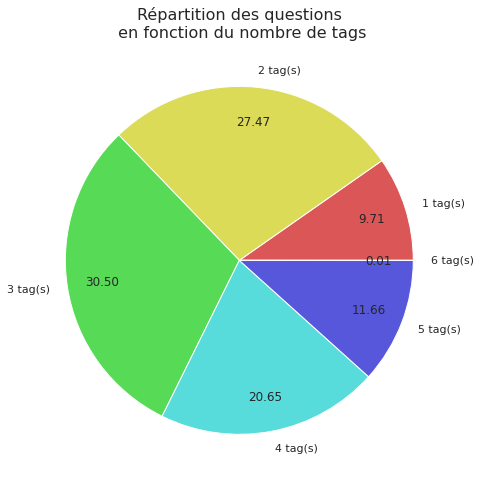

In [21]:
# Camembert pourcentages de questions par nombre de tags :

fig = plt.figure(figsize=(8, 8))

labels=[str(n) + ' tag(s)' for n in nb_tags.index]
plt.pie(nb_tags, labels=labels, colors=sns.hls_palette(n_colors=len(nb_tags), h=0.0), autopct='%.2f', pctdistance = 0.8)
plt.title('Répartition des questions\n en fonction du nombre de tags', size=16)

plt.show()

## Synonymes

Ici on souhaitait faire un remplacement de certains tags par leurs synonymes donnés par stackoverflow, mais ils ont déjà été remplacés !

In [22]:
df['dataset_tags_synonyms'].head()

,sourcetagname,targettagname
0,windows-forms,winforms
1,c-sharp,c#
2,hg,mercurial
3,dotnet,.net
4,threading,multithreading


In [23]:
dico_remplacement = df['dataset_tags_synonyms'].set_index('sourcetagname').to_dict()
mask = df_posts.tags_liste == df_posts.tags_liste.apply(lambda liste : [dico_remplacement.get(item, item) for item in liste])
mask.sum()
# apparemment les synonymes ont déjà été remplacés !

49120

## Fréquences

Dans cette partie nous donnons quelques statistiques sur les fréquences des tags et les tags les plus fréquents.

In [24]:
# Fréquences des tags associés aux questions :

tags_frequences = fonction_frequences(df_posts.tags_liste)

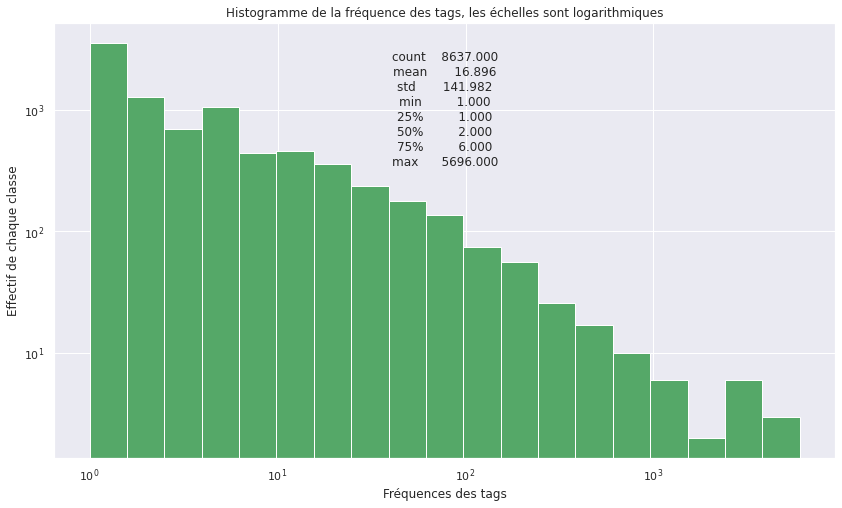

In [25]:
# Histogramme de la fréquence des tags

fig = plt.figure(figsize = (14,8))

frequences = pd.Series(list(tags_frequences.values())).sort_values(ascending=False)

logbins = np.logspace(np.log10(1), np.log10(6000), 20)
ax = frequences.hist(bins=logbins, color='g')

# Paramètres des axes :
plt.xscale('log'), plt.yscale('log')

plt.text(0.5, 0.8, frequences.describe().to_string(), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.title('Histogramme de la fréquence des tags, les échelles sont logarithmiques')
plt.xlabel('Fréquences des tags')
plt.ylabel('Effectif de chaque classe')

plt.show()

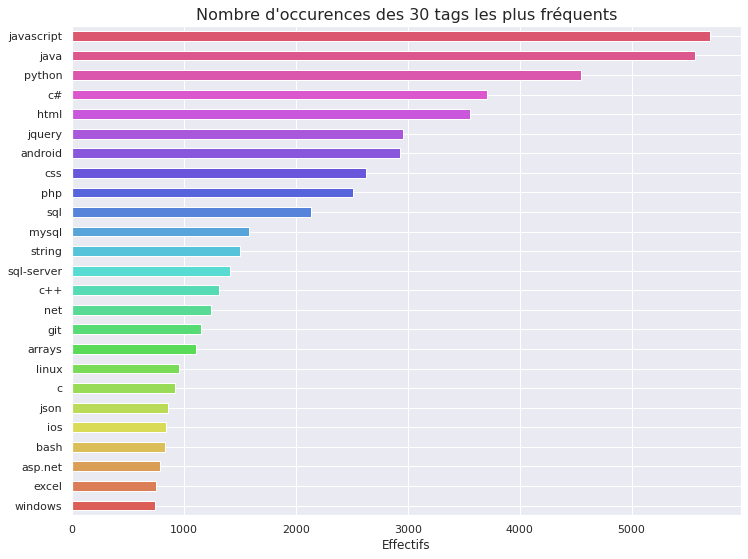

In [26]:
# Diagramme en barre des tags les plus fréquents

diagramme_bar_mots_plus_frequents(tags_frequences.most_common(25), 'Nombre d\'occurences des 30 tags les plus fréquents')

In [27]:
print([couple[0] for couple in tags_frequences.most_common(25)])

['javascript', 'java', 'python', 'c#', 'html', 'jquery', 'android', 'css', 'php', 'sql', 'mysql', 'string', 'sql-server', 'c++', 'net', 'git', 'arrays', 'linux', 'c', 'json', 'ios', 'bash', 'asp.net', 'excel', 'windows']


## Selection des tags les plus frequents

Pour nos futurs modèles nous allons devoir restreindre le nombre de tags dans la cible d'apprentissage.  
Pour bien évaluer le nombre de tags que nous allons selectionner nous allons regarder quelques statistiques (proportion de tags couverts, proportion de questions couvertes par au moins un tag, proportion de questions dont tous les tags sont couverts), en fonction du nombre de tags selectionnés.

In [28]:
# Fonctions pour les courbes du graphique suivant :

def intersection_non_nulle(liste1, liste2):
    for tag in liste1:
        if tag in liste2:
            return True
    return False


def liste1_inclue_dans_liste2(liste1, liste2):
    result = True
    for tag in liste1:
        if tag not in liste2:
            return False
    return result


# Fonction qui retourne les ordonnées Y où pour un entier n de X l'ordonnée correspondante de Y
# correspond au nb de questions couvertes par les n premiers tags.
def nb_questions_couvertes(X, all_tags=False):
    Y = []
    for n in X:
        most_common = [couple[0] for couple in tags_frequences.most_common(n)]
        if all_tags:
            y = df_posts.tags_liste.apply(lambda liste_tags: liste1_inclue_dans_liste2(liste_tags, most_common)).sum()
        else:
            y = df_posts.tags_liste.apply(lambda liste_tags: intersection_non_nulle(liste_tags, most_common)).sum()
        Y.append(y)
    
    return np.array(Y)



--- 40.39 seconds ---


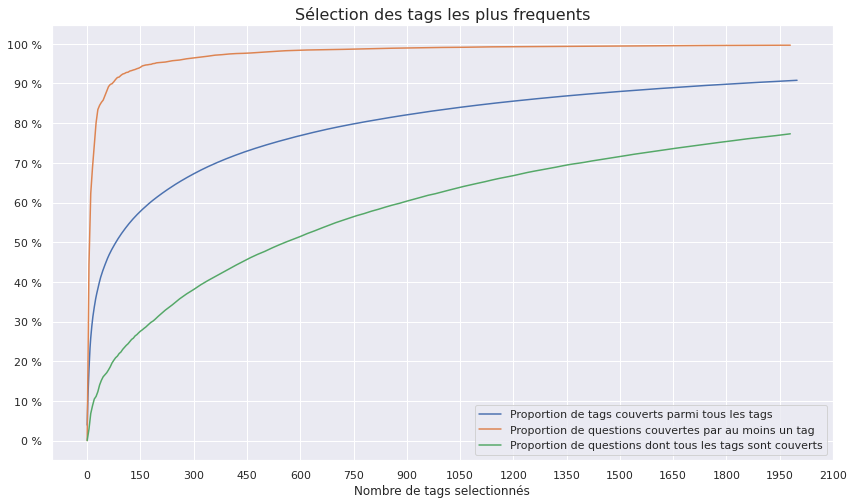

In [29]:
# Proportion de tags parmi tous les tags en fonction du nombre de tags pris en compte :

start_time = time.time()

fig = plt.figure(figsize = (14,8))

X = range(2000)
Y = 100 * frequences[:2000].cumsum() / frequences.sum()

plt.plot(X,Y)
X2 = list(range(0, 200, 5)) + list(range(200, 2000, 20))

Y2 = 100 * nb_questions_couvertes(X2) / len(df_posts)
plt.plot(X2,Y2)

Y3 = 100 * nb_questions_couvertes(X2, all_tags=True) / len(df_posts)
plt.plot(X2,Y3)


ax = plt.gca()

ax.set_xticks([150 * i for i in range(15)])
ax.set_xticklabels([str(150 * i) for i in range(0, 15)])
ax.set_yticks(range(0, 110, 10))
ax.set_yticklabels([str(i) + ' %' for i in range(0, 110, 10)])
ax.set_xlabel('Nombre de tags selectionnés')

# Pour ajouter en 2ème axe des abcisses les pourcentages de tags, mais ça ne le fait pas trop...
# ax2 = ax.twiny()
# ax2.set_xticks([i * 0.02 * len(frequences) for i in range(13)])
# print([i * 0.02 * len(frequences) for i in range(11)])
# ax2.set_xticklabels([str(i) + ' %' for i in range(0, 25, 2)])
# ax2.set_xlabel('Pourcentage de tags selectionnés')


plt.title('Sélection des tags les plus frequents', size=16)
ax.legend(['Proportion de tags couverts parmi tous les tags', 'Proportion de questions couvertes par au moins un tag', 'Proportion de questions dont tous les tags sont couverts'])


#plt.plot([0, 2000], [98, 98], color='grey')

print("--- {:.2f} seconds ---".format(time.time() - start_time))
plt.show()


In [30]:
# Fonction qui permet de ne conserver que les tags selectionnés dans notre dataframe :
# Les tags selectionnés sont les nb_tags_selectionnes les plus fréquents :

def selection_tags(nb_tags_selectionnes):
    most_common = [couple[0] for couple in tags_frequences.most_common(nb_tags_selectionnes)]

    df_posts['tags_selection'] = df_posts.tags_liste.apply(lambda liste_tags: list(set(liste_tags).intersection(set(most_common))))
    df_posts['nb_tags_selection'] = df_posts['tags_selection'].apply(len)



In [31]:
# Essai avec 300 tags

nb_tags_selectionnes = 300

selection_tags(nb_tags_selectionnes)

with pd.option_context('max_colwidth', 300):
  display(df_posts[['tags_liste', 'tags_selection', 'nb_tags_selection']].head())

,tags_liste,tags_selection,nb_tags_selection
0,"[php, file, file-upload]","[php, file, file-upload]",3
1,"[sql, sql-server, oracle, syntax, case]","[sql, syntax, oracle, sql-server]",4
2,"[fonts, development-environment]",[fonts],1
3,"[apache, htaccess, mod-rewrite]","[htaccess, apache]",2
4,"[android, android-dialogfragment]",[android],1


In [32]:
# Counts du nombre de tags par question après selection :

nb_tags_selection = df_posts.nb_tags_selection.value_counts().sort_index()
nb_tags_selection

0     1746
1    14494
2    19165
3    10155
4     3047
5      512
6        1
Name: nb_tags_selection, dtype: int64

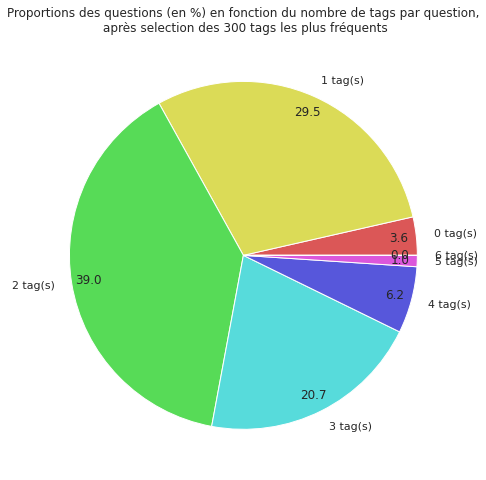

In [33]:
# Proportions des questions par nombre de tags

fig = plt.figure(figsize=(8, 8))

plt.pie(nb_tags_selection, labels=[str(n) + ' tag(s)' for n in nb_tags_selection.index], colors=sns.hls_palette(n_colors=len(nb_tags), h=0.0), autopct='%.1f', pctdistance = 0.9)
plt.title('Proportions des questions (en %) en fonction du nombre de tags par question,\n après selection des {} tags les plus fréquents'.format(nb_tags_selectionnes))

plt.show()

# IV - Questions : nettoyage et exploration

L'objectif dans cette partie est de réaliser la tokénisation et le nettoyage du corpus de questions. Chaque question sera obtenue par concaténation du 'title' et du 'body'.  
Dans un premier temps on supprime les tags html, puis on réalise une première tokénisation sans nettoyage (suppression de mots), ceci afin de pouvoir comparer les effets du futur nettoyage sur les statistiques des mots.

## Suppresion des tags html dans le body

In [34]:
# Fonction de suppression des balises html :

def delete_html_tags(text):
    p = re.compile(r'<.*?>')
    return p.sub('', text)

# Exemple :
delete_html_tags('<p>Many posters have problems debugging their RewriteRule and RewriteCond statements within their <strong><code>.htaccess</code></strong> files')

# Sinon librairie conseillée par Laura pour enlever les tags html : https://github.com/bmabey/pyLDAvis

'Many posters have problems debugging their RewriteRule and RewriteCond statements within their .htaccess files'

In [35]:
# On enlève les tags html du body et on créé la variable qui donne le texte d'une question
# en concaténant title et body :

df_posts['question_text'] = df_posts.title + ' ' + df_posts['body'].apply(delete_html_tags)


In [36]:
with pd.option_context('max_colwidth', 300):
  display(df_posts.head(3))

,tags,title,body,tags_liste,nb_tags,tags_selection,nb_tags_selection,question_text
0,<php><file><file-upload>,How to limit file upload type file size in PHP?,"<p>I have an upload form and am checking the file size and file type to limit the uploaded file to 2 megabytes and either .pdf, .jpg, .gif or .png file types. My goal is to have an alert message displayed to the user if they violate one of these rules.</p>\n\n<p>There are four scenarios:</p>\n\...","[php, file, file-upload]",3,"[php, file, file-upload]",3,"How to limit file upload type file size in PHP? I have an upload form and am checking the file size and file type to limit the uploaded file to 2 megabytes and either .pdf, .jpg, .gif or .png file types. My goal is to have an alert message displayed to the user if they violate one of these rule..."
1,<sql><sql-server><oracle><syntax><case>,SQL Case Expression Syntax?,<p>What is the <strong>complete</strong> and correct syntax for the SQL Case expression?</p>\n,"[sql, sql-server, oracle, syntax, case]",5,"[sql, syntax, oracle, sql-server]",4,SQL Case Expression Syntax? What is the complete and correct syntax for the SQL Case expression?\n
2,<fonts><development-environment>,Recommended Fonts for Programming?,"<p>What fonts do you use for programming, and for what language/IDE? I use <a href=""http://www.microsoft.com/downloads/details.aspx?familyid=22e69ae4-7e40-4807-8a86-b3d36fab68d3&amp;displaylang=en"" rel=""nofollow noreferrer"" title=""Consolas"">Consolas</a> for all my Visual Studio work, any other ...","[fonts, development-environment]",2,[fonts],1,"Recommended Fonts for Programming? What fonts do you use for programming, and for what language/IDE? I use Consolas for all my Visual Studio work, any other recommendations?\n"


## Tokenisation sans nettoyage (pour avoir un élément de comparaison)

In [37]:
# Tokenisation sans cleaning (o)

start_time = time.time()

df_posts['question_words_before_clean'] =  df_posts.question_text.apply(lambda text : tokenize_sentence(text))
df_posts['nb_words_before_clean'] = df_posts['question_words_before_clean'].apply(len)

print("--- {:.2f} seconds ---".format(time.time() - start_time))


--- 1.63 seconds ---


In [38]:
words_frequences = fonction_frequences(df_posts.question_words_before_clean)
words_frequences.most_common(10)


[('the', 191521),
 ('i', 189721),
 ('to', 157052),
 ('a', 121931),
 ('gt', 110780),
 ('lt', 102203),
 ('in', 83914),
 ('is', 77587),
 ('and', 67858),
 ('this', 55496)]

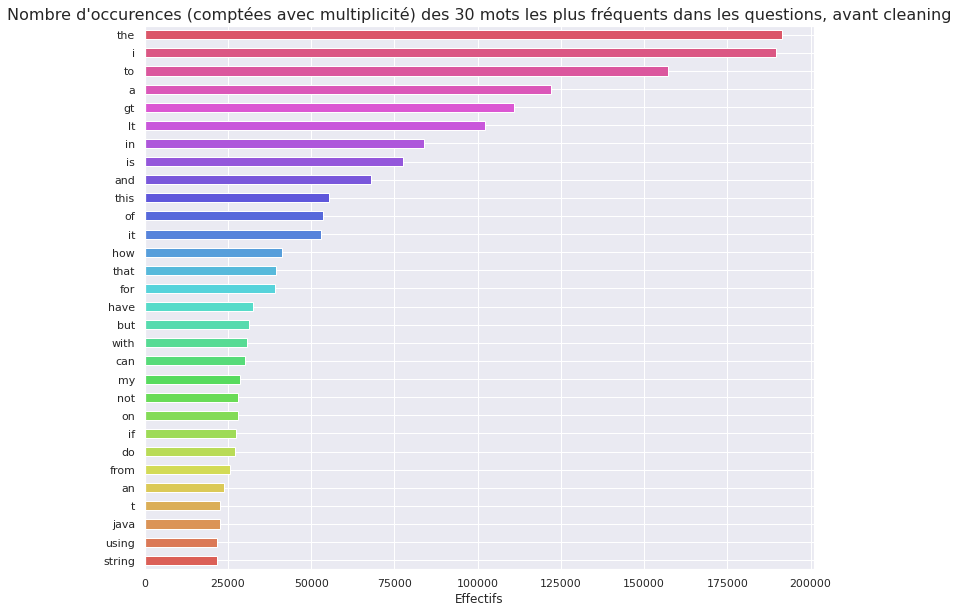

In [39]:
n = 30

diagramme_bar_mots_plus_frequents(words_frequences.most_common(n), title='Nombre d\'occurences (comptées avec multiplicité) des {} mots les plus fréquents dans les questions, avant cleaning'.format(n))

## Tokenisation avec lemmatisation et suppression de mots

On peut passer à la tokénisation avec suppression des mots les plus courants, les stopwords donnés par la librairie NLTK, auxquels on a ajouté retroactivement les mots les plus fréquents restant dans notre corpus, excepté les mots qui servent de tags.  
Les mots peu fréquents seront supprimés dans les modèles, lors de la vectorisation des données.

In [40]:
# Stopwords english

stopwords = nltk.corpus.stopwords.words('english')
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [41]:
# Ajout rétroactive de stopwords :

stopwords += ['lt', 'name', 'follow', 'way', 'exampl', 'run', 'error', 'work', 'type', 'use', 'tri', 'would', 'new', 'know', 'like', 'one', 'gt', 'code', 'creat', 'need', 'valu', 'want']
print('Nombre de stopwords = ', len(stopwords))

with open(chemin + 'stopwords.txt', "w") as file:
    file.write(str(stopwords))

Nombre de stopwords =  201


In [42]:
# On applique la tokénisation, avec lemmatisation :

start_time = time.time()

df_posts['question_words'] =  df_posts.question_text.apply(lambda text : tokenize_sentence(text, lemmatisation=True, stopwords=stopwords))
df_posts['nb_words_question'] = df_posts['question_words'].apply(len)

print("--- {:.2f} seconds ---".format(time.time() - start_time))


# On ajoute les mots avec des '-'
# réfléchir au pb des '.' dans les tags

--- 53.79 seconds ---


In [43]:
# Fonction de "détokénisation d'un texte", pour pouvoir donner notre corpus aux vectorizers :

def liste_to_text(liste_mots):
    if len(liste_mots) == 0:
        return ''
    texte = liste_mots[0]
    for mot in liste_mots[1:]:
        texte += ' ' + mot
    return texte

In [44]:
# On transforme à nouveau la question "nettoyée" en texte pour la suite :

df_posts['question_text_clean'] = df_posts.question_words.apply(liste_to_text)

In [45]:
# Visualisons le cleaning :

with pd.option_context('max_colwidth', 300):
  display(df_posts[['question_text', 'question_words']].head(3))

,question_text,question_words
0,"How to limit file upload type file size in PHP? I have an upload form and am checking the file size and file type to limit the uploaded file to 2 megabytes and either .pdf, .jpg, .gif or .png file types. My goal is to have an alert message displayed to the user if they violate one of these rule...","[limit, file, upload, file, size, php, upload, form, check, file, size, file, limit, upload, file, megabyt, either, pdf, jpg, gif, png, file, goal, alert, messag, display, user, violat, rule, four, scenario, correct, size, correct, correct, size, incorrect, incorrect, size, correct, incorrect, s..."
1,SQL Case Expression Syntax? What is the complete and correct syntax for the SQL Case expression?\n,"[sql, case, express, syntax, complet, correct, syntax, sql, case, express]"
2,"Recommended Fonts for Programming? What fonts do you use for programming, and for what language/IDE? I use Consolas for all my Visual Studio work, any other recommendations?\n","[recommend, font, program, font, program, languag, ide, consola, visual, studio, ani, recommend]"


## Statistiques sur le corpus

Dans cette partie nous réalisons quelques statisiques sur le corpus après cleaning : on regarde le nombre de mots par question et la fréquences des mots, notamment les mots les plus fréquents. 

### Nombres de mots dans les questions

In [46]:
# Statistiques sur le nombres de mots, le nombre de mots par question : 

words_frequences = fonction_frequences(df_posts.question_words)

# Nb de mots total :
print('Après tokénisation et lemmatisation :')
print('Nombre de mots dans le corpus = ', words_frequences.N())

# Mots uniques :
print('Nombre de mots uniques dans le corpus = ', words_frequences.B())
# aussi len(set(liste_words))

# Nb de mots par question :
print('Nombre moyen de mots par question (titre + body) = {:.1f}'.format(df_posts.nb_words_question.mean()))
print('Nombre minimal de mots par question (titre + body) = {}'.format(df_posts.nb_words_question.min()))
print('Nombre maximal de mots par question (titre + body) = {}'.format(df_posts.nb_words_question.max()))

Après tokénisation et lemmatisation :
Nombre de mots dans le corpus =  3108613
Nombre de mots uniques dans le corpus =  123722
Nombre moyen de mots par question (titre + body) = 63.3
Nombre minimal de mots par question (titre + body) = 2
Nombre maximal de mots par question (titre + body) = 3297


In [47]:
# Regardons les questions avec peu de mots :

mask = df_posts.nb_words_question <= 2
print(mask.sum())

with pd.option_context('max_colwidth', 100):
  display(df_posts[mask].head())

3


,tags,title,body,tags_liste,nb_tags,tags_selection,nb_tags_selection,question_text,question_words_before_clean,nb_words_before_clean,question_words,nb_words_question,question_text_clean
10982,<unit-testing><mocking>,What is Mocking?,<p>What is Mocking? ...,"[unit-testing, mocking]",2,[unit-testing],1,What is Mocking? What is Mocking? ...,"[what, is, mocking, what, is, mocking]",6,"[mock, mock]",2,mock mock
11698,<oop><polymorphism><computer-science>,"What is polymorphism, what is it for, and how is it used?","<p>What is polymorphism, what is it for, and how is it used?</p>\n","[oop, polymorphism, computer-science]",3,[oop],1,"What is polymorphism, what is it for, and how is it used? What is polymorphism, what is it for, ...","[what, is, polymorphism, what, is, it, for, and, how, is, it, used, what, is, polymorphism, what...",24,"[polymorph, polymorph]",2,polymorph polymorph
23378,<c#><.net><delegates>,"What is Func, how and when is it used",<p>What is <code>Func&lt;&gt;</code> and what is it used for?</p>\n,"[c#, net, delegates]",3,"[net, c#]",2,"What is Func, how and when is it used What is Func&lt;&gt; and what is it used for?\n","[what, is, func, how, and, when, is, it, used, what, is, func, lt, gt, and, what, is, it, used, ...",20,"[func, func]",2,func func


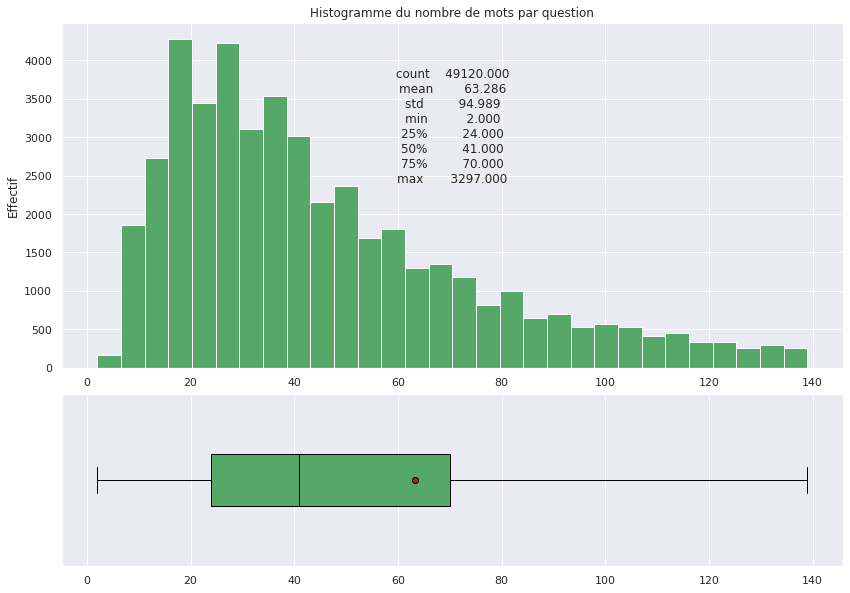

In [48]:
# Histogramme du nombre de mots par question après nettoyage

visualisation(df_posts.nb_words_question, coefIQR = 1.5, x_text=0.5, titre='Histogramme du nombre de mots par question', color='g')

### Fréquences des mots

#### Nombre de mots par fréquence d'apparition

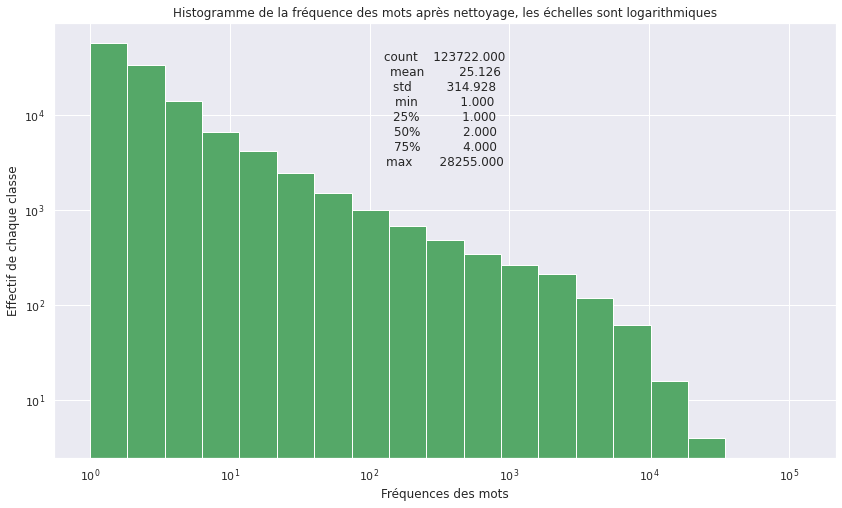

In [49]:
# Histogramme de la fréquence des mots après nettoyage

fig = plt.figure(figsize = (14,8))

frequences = pd.Series(list(words_frequences.values()))
logbins = np.logspace(np.log10(1), np.log10(120000), 20)
ax = frequences.hist(bins=logbins, color='g')

# Echelles log :
plt.xscale('log')
plt.yscale('log')

#plt.xticks([1,10,100,1000,10000], [1,10,100,1000,10000])

# Textes :
plt.title('Histogramme de la fréquence des mots après nettoyage, les échelles sont logarithmiques')
plt.text(0.5, 0.8, frequences.describe().to_string(), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.xlabel('Fréquences des mots')
plt.ylabel('Effectif de chaque classe')

plt.show()


#### Mots les plus fréquents

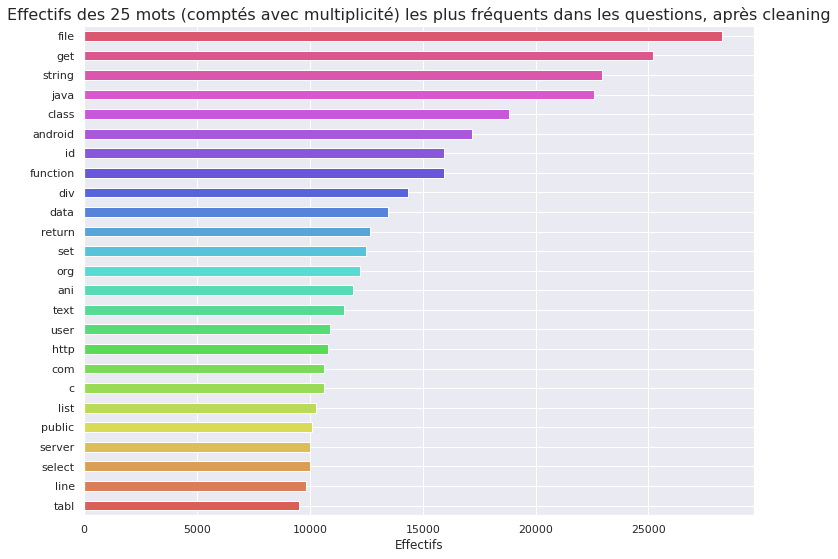

In [50]:
# Mots les plus fréquents dans les questions :

words_frequences = fonction_frequences(df_posts.question_words)


# Plot des plus gros counts :
n = 25
diagramme_bar_mots_plus_frequents(words_frequences.most_common(n), title='Effectifs des {} mots (comptés avec multiplicité) les plus fréquents dans les questions, après cleaning'.format(n))

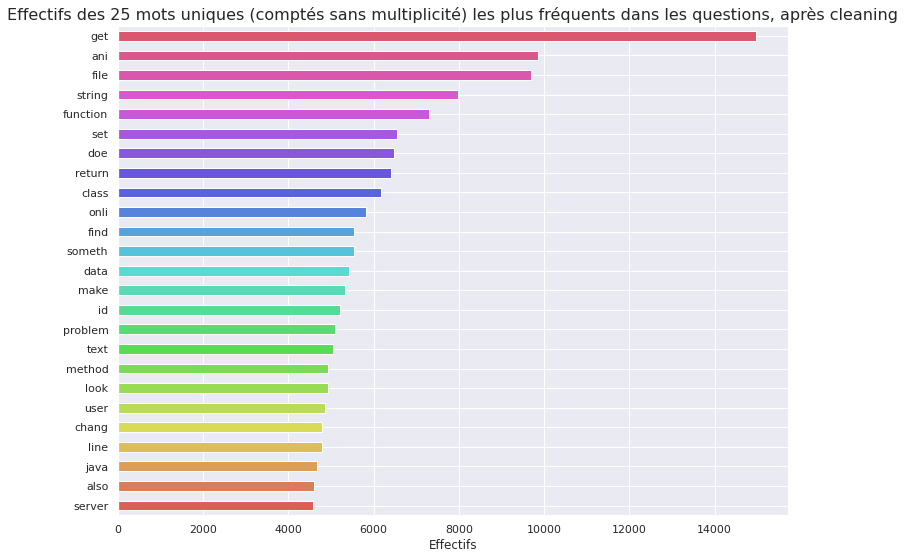

In [51]:
# Fréquences des mots (uniques) dans les questions :

words_frequences_uniques = fonction_frequences(df_posts.question_words, mots_uniques=True)

# Plot des plus gros counts :
diagramme_bar_mots_plus_frequents(words_frequences_uniques.most_common(n), title='Effectifs des {} mots uniques (comptés sans multiplicité) les plus fréquents dans les questions, après cleaning'.format(n))

In [52]:
# Pour checker les mots qui apparraissent n fois en tout, histoire d'estimer à quelle valeur fixer le min_df pour la suite
n_fois = 20

dico_frequences = dict(words_frequences.items())
dico = {k:v for k,v in dico_frequences.items() if v == n_fois}

liste_mots = []
for i in range (20):
    liste_mots.append(list(dico.items())[i][0])
    
print('Exemples de mots apparaissant {} fois dans le corpus :'.format(n_fois))
print(liste_mots)

Exemples de mots apparaissant 20 fois dans le corpus :
['onstop', 'scikit-learn', 'newdat', 'php5-fpm', 'wherev', 'curlopt_httphead', 'toplink', 'polynomi', 'lay', 'child2', 'removechild', 'scr', 'getclassload', 'probe', 'sock_stream', 'soapact', 'saxparseexcept', 'tee', 'mimic', 'greg']


## Ajout de Stopwords

In [53]:
# n = 30

# most_frequents = [couple[0] for couple in words_frequences_uniques.most_common(n)]

# most_frequents_not_in_tags = set(most_frequents) - set(liste_tags)
# most_frequents_in_tags = set(most_frequents) - most_frequents_not_in_tags

# print('Mots les plus fréquents qui sont dans les tags :', most_frequents_in_tags,'\n', sep='\n')
# print('Mots les plus fréquents qui ne sont pas dans les tags :', list(most_frequents_not_in_tags), sep='\n')


# # Mots les plus fréquents qui sont dans les tags :
# # {'file', 'set', 'return', 'get', 'find', 'function', 'string', 'class'}


# # Mots les plus fréquents qui ne sont pas dans les tags :
# # ['lt', 'name', 'follow', 'way', 'exampl', 'run', 'error', 'work', 'type', 'use', 'tri', 'would', 'new', 'know', 'like', 'one', 'gt', 'code', 'creat', 'need', 'valu', 'want']


# V - Vectorisations BOW et TF-IDF

Dans cette partie on créé la fonction de vectorisation de notre corpus, fonction qui sera intégrée à nos modèles.  
Le paramètre min_df contrôle le nombre de mots que l'on conserve pour la vectorisation : les mots dont le nombre d'occurences dans le corpus sont en-dessous de min_df seront supprimés.  
Les deux type de vectorisation que l'on va utiliser sont 'BOW' et 'TF-IDF'.

## Vectorisation fonctions

In [54]:
# Fonction qui réalise la vectorisation d'un corpus de texte, avec aux choix un bo(w ou n-gram) ou tf-idf :
# Les paramètres sont les suivants :
    # serie_str est le corpus de textes
    # vectorizer_type est de type 'bow' ou 'tfidf'
    # binary == True permet de ne pas compter les multiplicités dans un texte
    # ngram_range donne l'option de choisir des n-grams (ce sont des mots par défaut)

# La fonction retourne le triplet constitué du vocabulaire selectionné (dans le même ordre que la vectorisation), de la vectorisation des données X, et du vectorizer.

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def vectorizer_function(serie_str, vectorizer_type, min_df, binary=False, ngram_range = (1,1)):
    if vectorizer_type == 'bow':
        vectorizer = CountVectorizer(min_df=min_df, binary=binary, ngram_range=ngram_range, token_pattern='[A-Za-z][A-Za-z0-9_+\-#]*')
    elif vectorizer_type == 'tfidf':
        vectorizer = TfidfVectorizer(min_df=min_df, binary=binary, ngram_range=ngram_range, token_pattern='[A-Za-z][A-Za-z0-9_+\-#]*')
    
    X = vectorizer.fit_transform(serie_str)

    vocab = sorted(vectorizer.vocabulary_.items(), key=lambda item: item[1])
    
    vocabulary = []
    for couple in vocab:
        vocabulary.append(couple[0])

    return (vocabulary, X, vectorizer)


In [55]:
# Fonction qui permet de voir les résultats d'une vectorisation sur une question donnée
# i est l'indice de la question donnée dans le dataframe, les autres paramètres sont ceux de la fonction précédente :

def show_vectorisation(i, vectorizer_type, min_df, binary=False, ngram_range = (1,1)):

    print('Question initiale :', df_posts.question_text[i], '\n')
    print('Liste de mots après cleaning :', df_posts.question_words[i], '\n')
    print('Vectorisation {} :'.format(vectorizer_type))

    serie = df_posts.question_text_clean
    (vocabulary, X, vectorizer) = vectorizer_function(serie, vectorizer_type=vectorizer_type, min_df=min_df, binary=binary, ngram_range = ngram_range)
    
    vocab = vectorizer.vocabulary_ # ça peut être codé plus joliment en utilisant direct vocabulary
    question_words = vectorizer.build_tokenizer()(serie[i])  

    dico = {}
    for word in question_words:
        if word in vocab:
            indice = vocab[word]
            dico[word] = X[i, indice]
        else:
            dico[word] = 0
    return sorted(dico.items(), key=lambda item: item[1], reverse=True)

    # fonction d'affichage à adapter pour afficher les bigrammes... si besoin...


## Nombre de mots selectionnés (i.e. de features) en fonction de min_df

--- 14.24 seconds ---


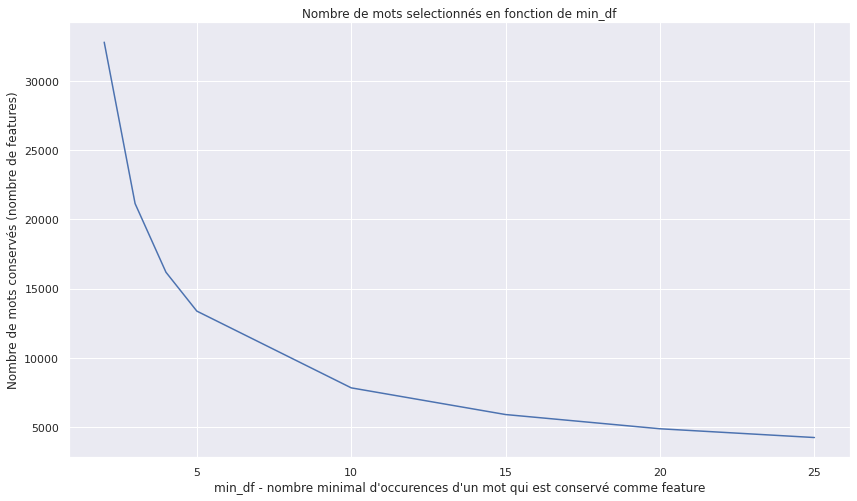

In [56]:
start_time = time.time()

liste_nb_features =[]
X = list(range(2, 5)) + list(range(5, 30, 5))

for min_df in X:
    V = vectorizer_function(df_posts.question_text_clean, vectorizer_type='bow', min_df=min_df)[1]
    liste_nb_features.append(V.shape[1])

print("--- {:.2f} seconds ---".format(time.time() - start_time))

liste_nb_features


fig = plt.figure(figsize = (14,8))

plt.plot(X,liste_nb_features)

plt.title('Nombre de mots selectionnés en fonction de min_df')
plt.xlabel('min_df - nombre minimal d\'occurences d\'un mot qui est conservé comme feature')
plt.ylabel('Nombre de mots conservés (nombre de features)')

plt.show()

## Questions après vectorisation

Dans cette partie on regarde (encore une fois) la liste des mots après un dernier nettoyage par le vectoriseur, qui effectue la suppresion des mots peu fréquents, suppression gérée par le paramètre 'min_df'.

In [57]:
(vocabulary, X_bow, vectorizer) = vectorizer_function(df_posts.question_text_clean, vectorizer_type='bow', min_df=50)

print(X_bow.shape)


(49120, 2771)


In [58]:
# Bow mots uniques :
df_posts['question_words_2_uniques'] = vectorizer.inverse_transform(X_bow)

# Nb de mots uniques :
df_posts['nb_uniques_words'] = df_posts.question_words_2_uniques.apply(len)


In [59]:
# Questions avec peu de mots :

mask = df_posts.nb_uniques_words <= 1
print(mask.sum())

with pd.option_context('max_colwidth', 300):
  display(df_posts[mask].head(3))


# Pour min_df au dessus de 15 j'ai des questions sans mot après suppression des low counts
# On pourrait éventuellement supprimer ces questions ? --> non c'est pas grave nos modèles ne prédiront aucun tag pour ces questions !

16


,tags,title,body,tags_liste,nb_tags,tags_selection,nb_tags_selection,question_text,question_words_before_clean,nb_words_before_clean,question_words,nb_words_question,question_text_clean,question_words_2_uniques,nb_uniques_words
1738,<jndi>,What is JNDI? What is its basic use? When is it used?,<ul>\n<li><p>What is <em>JNDI</em>?</p></li>\n<li><p>What is its basic use?</p></li>\n<li><p>When is it used?</p></li>\n</ul>\n,[jndi],1,[],0,What is JNDI? What is its basic use? When is it used? \nWhat is JNDI?\nWhat is its basic use?\nWhen is it used?\n\n,"[what, is, jndi, what, is, its, basic, use, when, is, it, used, what, is, jndi, what, is, its, basic, use, when, is, it, used]",24,"[jndi, basic, jndi, basic]",4,jndi basic jndi basic,[basic],1
4254,<java><servlets>,init-param and context-param,<p>What is the difference between <code>&lt;init-param&gt;</code> and <code>&lt;context-param&gt;</code> !?</p>\n,"[java, servlets]",2,"[java, servlets]",2,init-param and context-param What is the difference between &lt;init-param&gt; and &lt;context-param&gt; !?\n,"[init-param, and, context-param, what, is, the, difference, between, lt, init-param, gt, and, lt, context-param, gt]",15,"[init-param, context-param, differ, init-param, context-param]",5,init-param context-param differ init-param context-param,[differ],1
4859,<linux><multithreading><synchronization><mutex><semaphore>,When should we use mutex and when should we use semaphore,<p>When should we use mutex and when should we use semaphore ?</p>\n,"[linux, multithreading, synchronization, mutex, semaphore]",5,"[linux, multithreading]",2,When should we use mutex and when should we use semaphore When should we use mutex and when should we use semaphore ?\n,"[when, should, we, use, mutex, and, when, should, we, use, semaphore, when, should, we, use, mutex, and, when, should, we, use, semaphore]",22,"[mutex, semaphor, mutex, semaphor]",4,mutex semaphor mutex semaphor,[],0


## Vectorisation exemples

Dans cette partie on donne des exemples de vectorisation sur des questions choisies.

In [60]:
show_vectorisation(2564, vectorizer_type='bow', min_df=15)

Question initiale : How do you do exponentiation in C? I tried "x = y ** e", but that didn't work.
 

Liste de mots après cleaning : ['exponenti', 'c', 'x', 'e'] 

Vectorisation bow :


[('exponenti', 1), ('c', 1), ('x', 1), ('e', 1)]

In [61]:
show_vectorisation(2, vectorizer_type='bow', min_df=15)

Question initiale : Recommended Fonts for Programming? What fonts do you use for programming, and for what language/IDE?  I use Consolas for all my Visual Studio work, any other recommendations?
 

Liste de mots après cleaning : ['recommend', 'font', 'program', 'font', 'program', 'languag', 'ide', 'consola', 'visual', 'studio', 'ani', 'recommend'] 

Vectorisation bow :


[('recommend', 2),
 ('font', 2),
 ('program', 2),
 ('languag', 1),
 ('ide', 1),
 ('visual', 1),
 ('studio', 1),
 ('ani', 1),
 ('consola', 0)]

In [62]:
show_vectorisation(2, vectorizer_type='tfidf', min_df=15)

Question initiale : Recommended Fonts for Programming? What fonts do you use for programming, and for what language/IDE?  I use Consolas for all my Visual Studio work, any other recommendations?
 

Liste de mots après cleaning : ['recommend', 'font', 'program', 'font', 'program', 'languag', 'ide', 'consola', 'visual', 'studio', 'ani', 'recommend'] 

Vectorisation tfidf :


[('font', 0.5538372847985193),
 ('recommend', 0.5473662350055364),
 ('program', 0.37077395697117116),
 ('ide', 0.28266826343905704),
 ('languag', 0.24075794489104757),
 ('visual', 0.23399936777415312),
 ('studio', 0.22050808254959114),
 ('ani', 0.12221246173199518),
 ('consola', 0)]

# VI - Word2vect et t-SNE

## Fonctions

In [63]:
# Fonction word2vec

import multiprocessing
from gensim.models import Word2Vec

# La fonction suivante effectue la vectorisation de la serie questions, 
# chaque question étant tokénisée (liste de mots).
# La fonction retourne le modèle.

def word2Vec_function(questions, min_count=50, dimension=100):
    start_time = time.time()

    # La liste de listes de mots envoyée au modèle
    sent = []
    for list_words in questions:
        sent.append(list_words)

    word2Vec = Word2Vec(sent,
                    min_count=min_count, # df_min                 
                    size= dimension, # dimension
                    # sample =  # The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial
                    workers=3, # number of partitions, default = 3
                    window =3, # The maximum distance between a target word and words around the target word. The default window is 5.
                    sg = 1)   # 0 --> CBOW, 1 --> skipgram
    print("--- {:.2f} seconds ---".format(time.time() - start_time))

    return word2Vec

In [64]:
# cosine similarity

def most_similar(liste_mots, model, nb_mots_similaire):
  df = pd.DataFrame()
  for mot in liste_mots:
    most_similar = model.similar_by_word(mot, nb_mots_similaire)
    mots = [couple[0] for couple in most_similar]
    indices = [couple[1] for couple in most_similar]
    df[mot] = mots
    df[mot + '_similarity'] = indices
  return df

In [65]:
# Fonction de réduction et de visualisation d'un t-SNE et à partir d'un modèle word2vec sur les mots les plus proches du mot 'word'.

from sklearn.manifold import TSNE

def tsnescatterplot(model, word, nb_words, perplexity=15):
    
    # Liste des mots similaires :
    most_similar = [couple[0] for couple in model.similar_by_word(word, nb_words)]
    word_labels = [word] + most_similar
    
    # Vecteurs
    X = model.wv.__getitem__(word_labels)
    
    # t-SNE 2 dimensions
    
    Y = TSNE(n_components=2, random_state=0, perplexity=perplexity).fit_transform(X)
    
    fig = plt.figure(figsize=(15,13))
    
    # Affichage des points :
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.scatter(x_coords, y_coords)
    plt.scatter(Y[0, 0], Y[0, 1], c='red')


    # Affichage des mots :
    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(3, 3), textcoords='offset points', size=12)
    
    plt.xlim(Y[:, 0].min()-20, Y[:, 0].max()+20)
    plt.ylim(Y[:, 1].min()-20, Y[:, 1].max()+20)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))




## Résultats

### Sur le corpus de questions

In [66]:
word2Vec = word2Vec_function(df_posts.question_words, min_count=20, dimension=100)

--- 26.63 seconds ---


In [67]:
most_similar(['python', 'panda', 'sql', 'regex'], word2Vec, 10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


,python,python_similarity,panda,panda_similarity,sql,sql_similarity,regex,regex_similarity
0,python3,0.728,datafram,0.824,t-sql,0.773,a-z,0.801
1,anaconda,0.687,pyspark,0.738,mssql,0.770,replaceal,0.738
2,pypi,0.686,df,0.732,db2,0.725,regexp,0.738
3,scikit-learn,0.678,dplyr,0.715,claus,0.700,pattern,0.725
4,scipi,0.676,sklearn,0.715,ssms,0.671,a-za-z0-9,0.723
5,pip3,0.667,read_csv,0.698,preparedstat,0.656,alphanumer,0.715
6,ipython,0.667,pd,0.694,tsql,0.653,hyphen,0.708
7,nltk,0.664,spark,0.690,mysql,0.652,regular,0.707
8,easy_instal,0.654,scikit-learn,0.686,subqueri,0.651,punctuat,0.707
9,pyqt4,0.648,numpi,0.683,toad,0.648,case-insensit,0.705


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


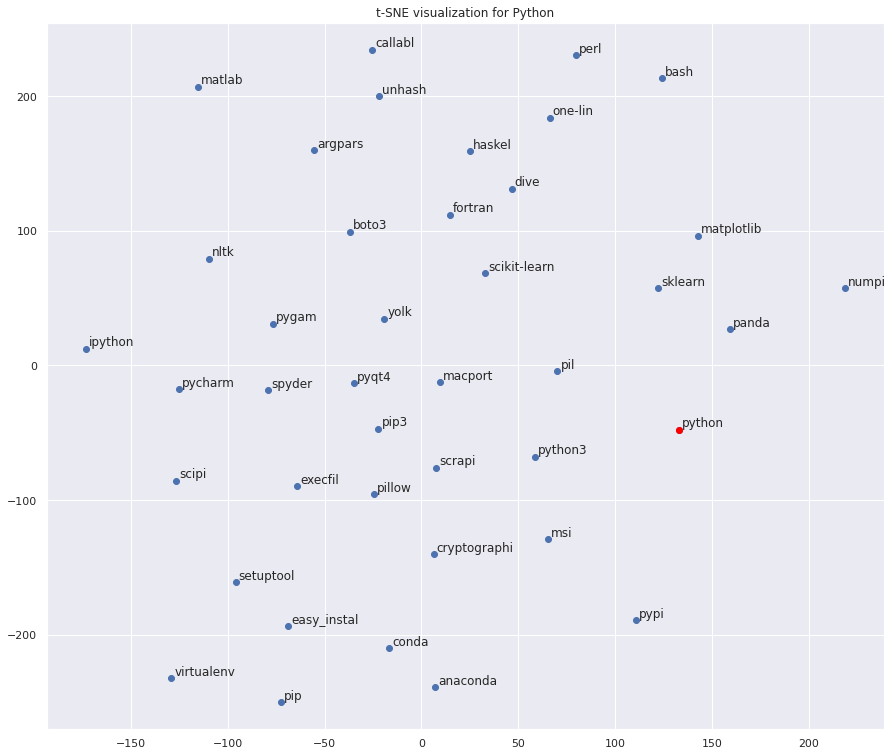

In [68]:
tsnescatterplot(word2Vec, 'python', 40, perplexity=10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


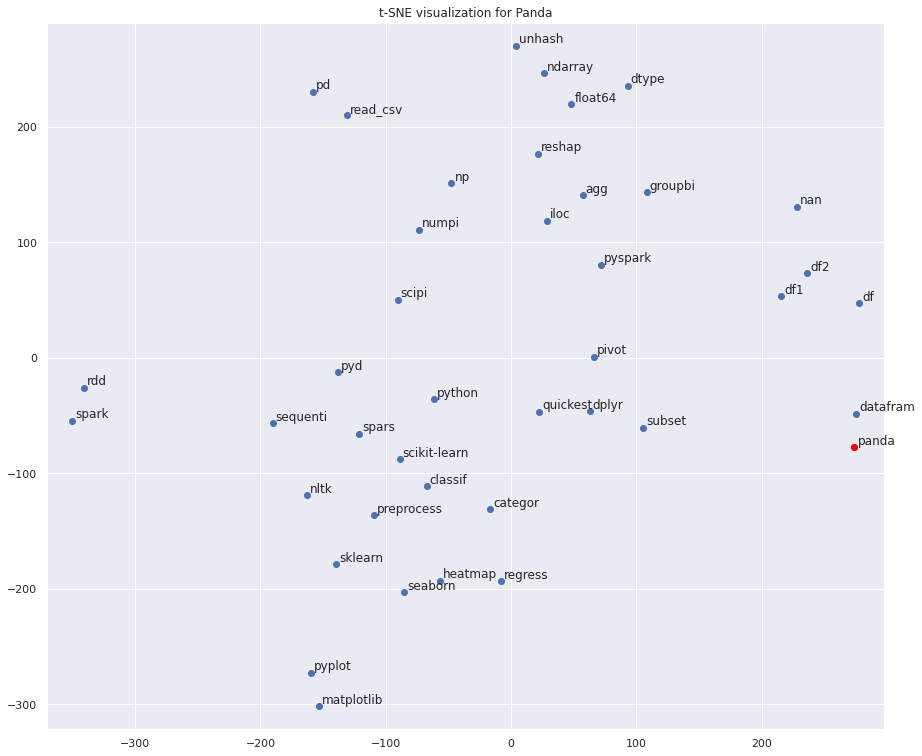

In [69]:
tsnescatterplot(word2Vec, 'panda', 40, perplexity=5)

### Sur le corpus de tags :

In [70]:
word2Vec = word2Vec_function(df_posts.tags_liste, min_count=50, dimension=100)

--- 0.50 seconds ---


In [71]:
most_similar(['python', 'git', 'pandas', 'matplotlib', 'sql', 'regex'], word2Vec, 10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


,python,python_similarity,git,git_similarity,pandas,pandas_similarity,matplotlib,matplotlib_similarity,sql,sql_similarity,regex,regex_similarity
0,plot,0.922,branch,0.954,r,0.976,numpy,0.994,plsql,0.990,escaping,0.935
1,dataframe,0.919,git-branch,0.949,matplotlib,0.975,python-2.7,0.987,oracle11g,0.988,filter,0.929
2,numpy,0.910,version-control,0.947,apache-spark,0.967,python-3.x,0.985,database,0.981,error-handling,0.926
3,python-2.7,0.901,github,0.927,numpy,0.965,pandas,0.975,insert,0.976,notepad++,0.924
4,matplotlib,0.897,ssh,0.883,django,0.952,plot,0.964,stored-procedures,0.976,perl,0.922
5,ggplot2,0.895,jenkins,0.875,python-2.7,0.950,pip,0.959,ssms,0.972,whitespace,0.922
6,python-3.x,0.895,svn,0.873,r-faq,0.945,matrix,0.957,database-design,0.970,variables,0.917
7,matrix,0.892,terminal,0.848,python-3.x,0.944,r-faq,0.955,sql-server-2008-r2,0.968,smtp,0.916
8,r-faq,0.887,macos,0.848,matrix,0.941,apache-spark,0.954,tsql,0.965,terminology,0.914
9,pip,0.879,installation,0.838,plot,0.929,r,0.949,sql-server-2005,0.964,numbers,0.914


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


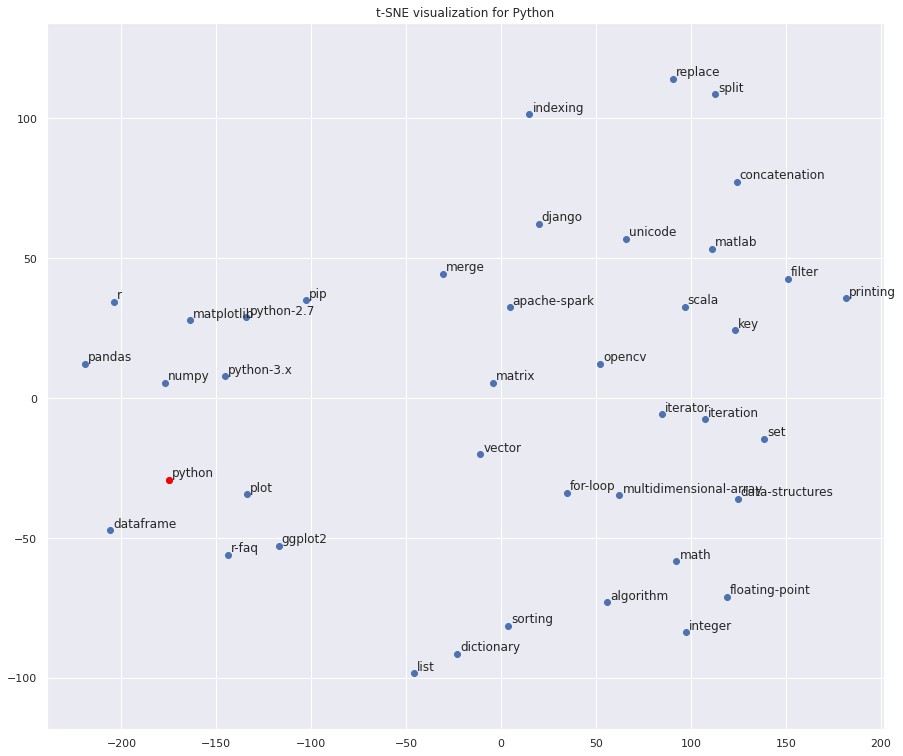

In [72]:
tsnescatterplot(word2Vec, 'python', 40, perplexity=10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


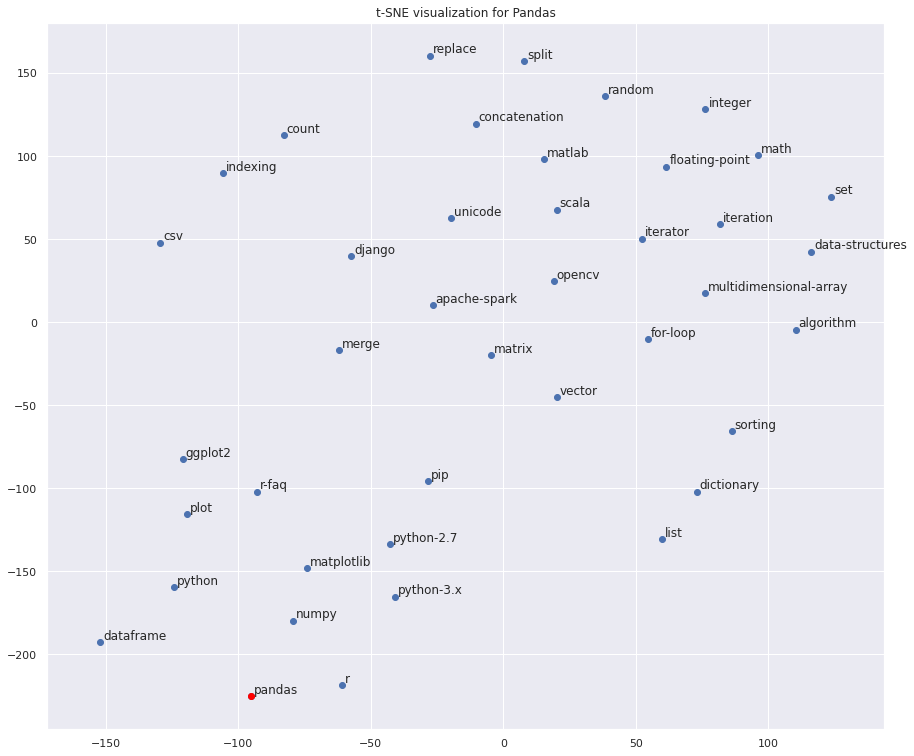

In [73]:
tsnescatterplot(word2Vec, 'pandas', 40, perplexity=15)

# Export du dataframe nettoyé

In [74]:
df_posts.to_pickle(path = chemin + 'df_posts')
